# K-means implementation for Cuda

--------

# Introduction

# I. Preliminaries

- ### Imports

In [6]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline  

- ### Simulate data

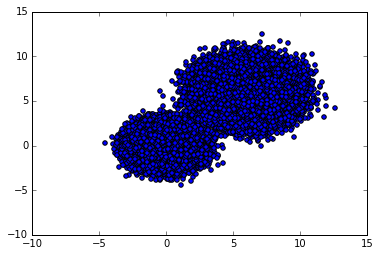

In [234]:
nb_point=100000
X = np.concatenate([np.random.multivariate_normal([0,0],[[1,0],[0,1]],nb_point),
                  np.random.multivariate_normal([6,6],[[2,0],[0,2]],nb_point)])

plt.scatter(X[:,0],X[:,1])
#change plot size

# II. Sequential approach

- ### Stanford approach

In [154]:
# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).
def kmeans(dataSet, k,MAX_ITERATIONS):
	
    # Initialize centroids randomly
    numFeatures = getNumFeatures(dataSet)
    centroids = getRandomCentroids(numFeatures, k)
    
    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = None
    
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations,MAX_ITERATIONS):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids = centroids
        iterations += 1
        
        # Assign labels to each datapoint based on centroids
        labels = getLabels(dataSet, centroids)
        
        # Assign centroids based on datapoint labels
        centroids = getCentroids(dataSet, labels, k)
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    clusters=getClusters(dataSet,centroids,k)
    return centroids, clusters


# Function: Should Stop
# -------------
# Returns True or False if k-means is done. K-means terminates either
# because it has run a maximum number of iterations OR the centroids
# stop changing.
def shouldStop(oldCentroids, centroids, iterations,MAX_ITERATIONS):
    if iterations > MAX_ITERATIONS : #| oldCentroids == centroids : 
        return True
    else:
        return False
    

# Function: Get Labels
# -------------
# Returns a label for each piece of data in the dataset. 
def getLabels(dataSet, centroids):
    # For each element in the dataset, chose the closest centroid. 
    # Make that centroid the element's label.
    mat=np.zeros(np.shape(dataSet))
    i=0
    for row in dataSet:
        dist=np.sqrt(((row-centroids)**2).sum(axis=1))
        index=np.argmin(dist,axis=0)
        mat[i]=centroids[index]
        i=i+1
    return mat


# Function: Get Centroids
# -------------
# Returns k random centroids, each of dimension n.
def getCentroids(dataSet, labels, k):
    # Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.
    
    #check centroids who are missing:
    sorted_data =  labels[np.lexsort(labels.T),:]
    row_mask = np.append([True],np.any(np.diff(sorted_data,axis=0),1))
    uniques=sorted_data[row_mask]
    i=0
    for row in labels:
        if row not in uniques:
            i=i+1
            
    #compute mean:
    centroids=np.zeros(np.shape(uniques))
    j=0
    for row in uniques:
        index=np.where(np.all(labels==row,axis=1))[0]
        #print(np.mean(dataSet[index],axis=0))
        centroids[j]=np.mean(dataSet[index],axis=0)
        j=j+1

    #concat with random missing centroids:
    return centroids
    #np.concatenate(centroids,np.random.random([i,np.shape(dataSet)[1]]))
    
def getRandomCentroids(numFeatures, k):
    return np.random.random([k,numFeatures])

def getNumFeatures(dataSet):
    return np.shape(dataSet)[1]

def getClusters(dataSet,centroids,k):
    clusters= [None]*np.shape(dataSet)[0] #np.zeros((1,np.shape(dataSet)[1]))
    for i,x in enumerate(dataSet):
        clusters[i] = min(range(k), key=lambda j: np.sqrt(((dataSet[i]-centroids[j])**2).sum(axis=0)))
    return clusters

In [237]:
%%time
t=kmeans(X,2,100)

CPU times: user 2min 30s, sys: 596 ms, total: 2min 31s
Wall time: 2min 31s


CPU times: user 380 ms, sys: 0 ns, total: 380 ms
Wall time: 377 ms


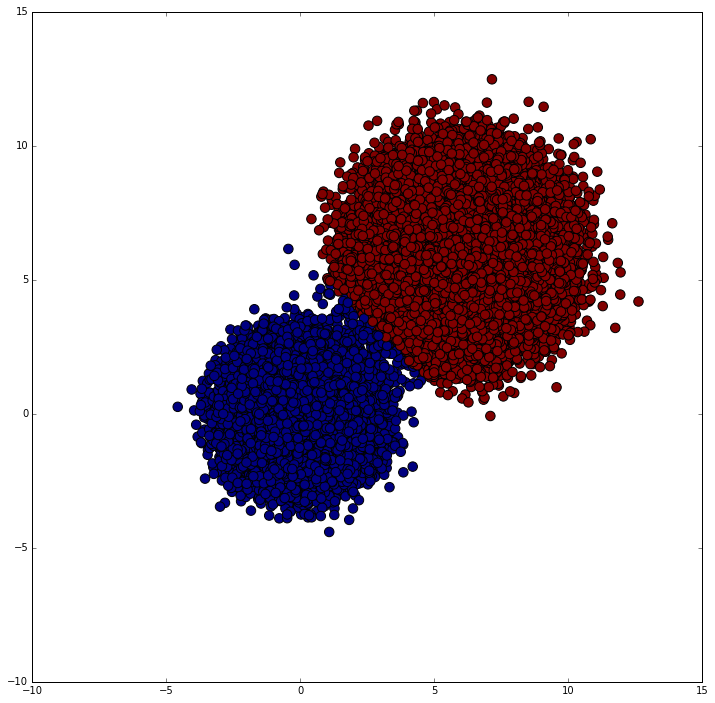

In [238]:
%%time
plt.figure(num=None, figsize=(12,12), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(X[:,0],X[:,1],c=t[1],s=90)

# III. Parallel approach